# Build a Traffic Sign Recognition Classifier

###  The goals of my project are the following:
* Load the data set
* Explore, summarize and visualize the data set
* Design, train and test a model architecture
* Use the model to make predictions on new images
* Analyze the softmax probabilities of the new images
* Summarize the results with a written report

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
training_file = "traffic-signs-data/train.p"
validation_file = "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration


### The summary of the dataset
I used the numpy library to calculate summary statistics of the traffic signs data set

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = (X_train.shape[1:4])

# Number of unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of valid examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of valid examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Choose 5 images from training set randomly and show them

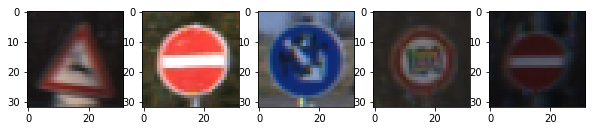

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

imgs_index = np.random.randint(len(X_train), size=5)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10,10))
for i, index in enumerate(imgs_index):
    ax[i].imshow(X_train[index])

###  Visualize the number of each traffic sign examples

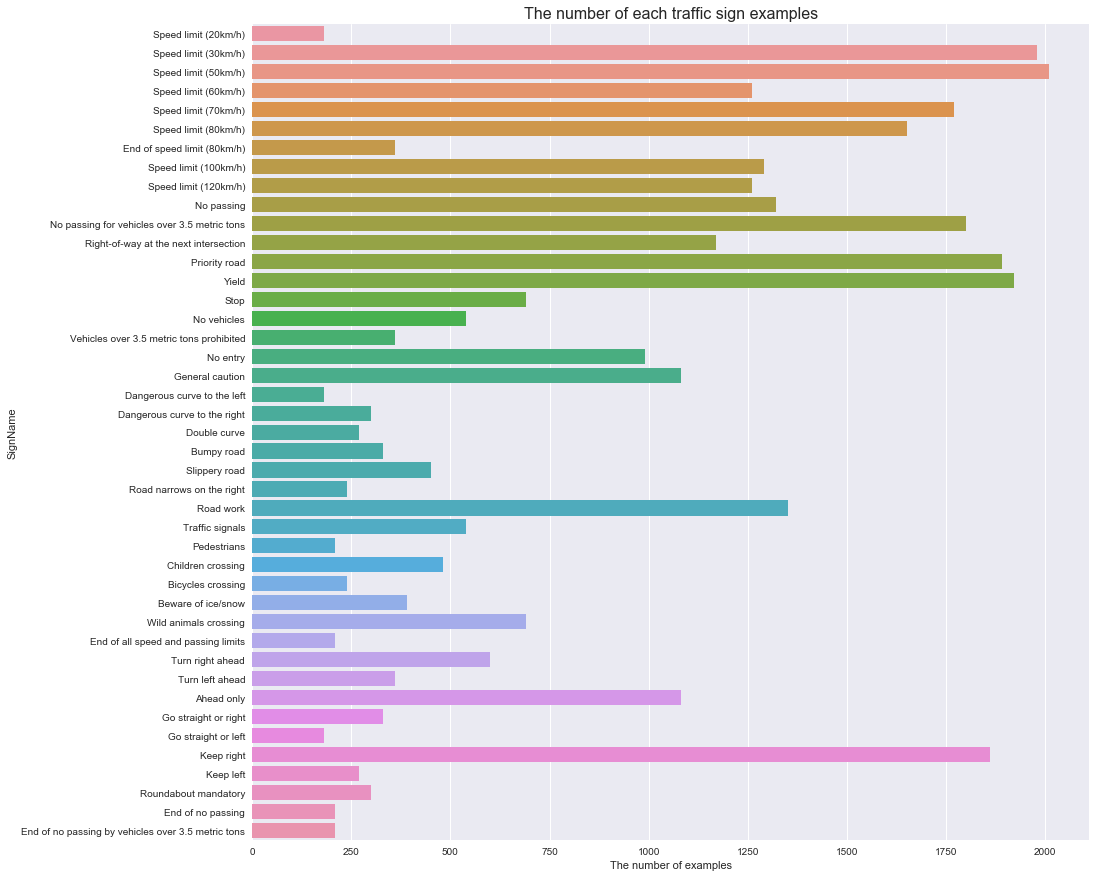

In [4]:
import pandas as pd
import seaborn as sns

# Read the signnames file
signnames = pd.read_csv("./signnames.csv")

# Count the number of each traffic sign examples
counts = []
for i in signnames["ClassId"]:
    count = list(y_train).count(i)
    counts.append(count)
signnames["Counts"] = counts

# Visualize the counts
fig, ax = plt.subplots(figsize=(15, 15))
sns.set_color_codes("muted")
sns.barplot(x="Counts", y="SignName", data=signnames)
ax.set_xlabel('The number of examples')
ax.set_title('The number of each traffic sign examples', fontsize=16)

----

## Step 2: Design and Test a Model Architecture

### Process the data set

First I converted the images to grayscale because color is helpless to identify objects in images and grayscale could reduce the computing effort. Secondly I normalized the image data because scaling feature values in a similar range could make gradients in control.

In [5]:
# Grayscale method
def grayscale(img):
    return np.sum(img/3, axis=2, keepdims=True)

# Normalize method
def normalize(img):
    return img/255

def processing(data):
    new_data = []
    for img in data:
        img = grayscale(img)
        img = normalize(img)
        new_data.append(img)
    return np.array(new_data)

Here is some random examples of  traffic sign images before and after processing.

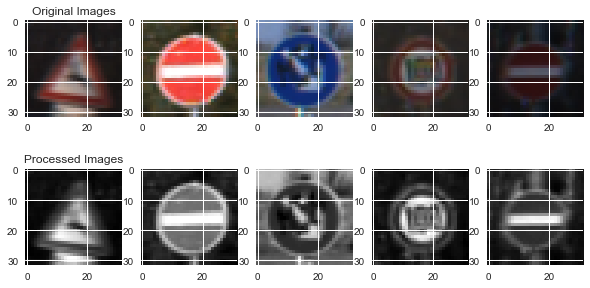

In [6]:
h, w = X_train.shape[1:3]

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,5))
for i, index in enumerate(imgs_index):
    ax[0][i].imshow(X_train[index])
    ax[1][i].imshow(np.reshape(processing(X_train)[index], (h,w)), cmap="gray")
ax[0][0].set_title("Original Images")
ax[1][0].set_title("Processed Images")

I decided to generate additional data because more data might help to improve model accuracy. 
To add more data to the the data set, I used brightening because I noticed some of original images are very dark, and improving the image contrast might help to fine edges of the image. Another technique I used is affine transform because a little perspective might be closer to the reality.

In [7]:
from PIL import Image
from PIL import ImageEnhance
import cv2

# Brighten method
def brighten(img, brightness=1.5):
    img = Image.fromarray(img)
    enh_bri = ImageEnhance.Brightness(img)
    img_brightened = enh_bri.enhance(brightness)
    return np.array(img_brightened)

# Affine transform method
def affine_transform(img):
    pts1 = np.float32([[5,5], [27,5], [5,27]])
    rd = np.random.randint(-3,3)
    pts2 = np.float32([[5+rd,5+rd], [27-rd,5+rd], [5+rd,27-rd]])
    M = cv2.getAffineTransform(pts1, pts2)
    img_transformed = cv2.warpAffine(img,M,(32, 32))
    return img_transformed

def transform(data):
    new_data = []
    for img in data:
        img = brighten(img)
        img = affine_transform(img)
        new_data.append(img)    
    return np.array(new_data)

Here is some random examples of original images and augmented images:

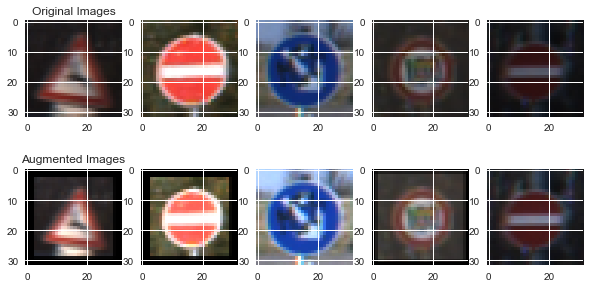

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,5))
for i, index in enumerate(imgs_index):
    ax[0][i].imshow(X_train[index])
    ax[1][i].imshow(transform(X_train)[index])
ax[0][0].set_title("Original Images")
ax[1][0].set_title("Augmented Images")

In [9]:
# Combine the training set and validation set
X_ = np.append(X_train, X_valid, axis=0)
y_ = np.append(y_train, y_valid, axis=0)

# Process the features
X_ = np.vstack((X_, transform(X_)))
y_ = np.tile(y_, 2)

In [10]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Shuffle and Split the data into training and validation subsets
X_, y_= shuffle(X_, y_)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.05, random_state=0)

print(X_train.shape, X_valid.shape)

(74497, 32, 32, 3) (3921, 32, 32, 3)


In [11]:
X_train = processing(X_train)
X_valid = processing(X_valid)
X_test = processing(X_test)

### Model Architecture

I used LeNex Model Architeture which consists of the following layers:

| Layer | Description |
| ----- | ----------- |
| Input | 32x32x1 Gray Image |
|Convolution 5x5 | 1x1 stride, valid padding, outputs 28x28x6 |
| RELU |  |
| Max pooling | 2x2 stride, valid padding, outputs 14x14x6 |
| Convolution 5x5 | 1x1 stride, valid padding, outputs 10x10x16 |
| RELU |
| Max pooling |	2x2 stride, valid padding, outputs 5x5x16 |
| Fully connected | outputs 400 |	
| Fully connected |	outputs 120 |
| RELU |
| Fully connected | outputs 84 |
| RELU |
| Dropout | 50% keep |
| Fully connected |	outputs 43 |

In [12]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, mu=0, sigma=0.1, strides=[1,1,1,1], ksize=[1,2,2,1], pool_strides=[1,2,2,1], keep_prob=0.5, padding="VALID"):
    
    # layer1, convolutional
    w1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean=mu, stddev=sigma))
    b1 = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, w1, strides, padding) + b1
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize, pool_strides, padding)
    
    # layer2, convolutional
    w2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    b2 = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, w2, strides, padding) + b2
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize, pool_strides, padding)
    
    # fully conneted
    fc0 = flatten(conv2)
    
    # layer3, fully conneted
    w3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    b3 = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0,w3) + b3
    fc1= tf.nn.relu(fc1)
    
    # layer4, fully conneted and dropout half outputs
    w4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    b4 = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,w4) + b4
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # layer5, fully conneted
    w5 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=mu, stddev=sigma))
    b5 = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2,w5) + b5
    
    return logits

### Train, Validate and Test the Model

To train the model, I used hyperparameters as the following:

In [13]:
epochs = 35
batch_size = 128
lr = 0.001 

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
targets = tf.one_hot(y, 43)

In [15]:
logits = LeNet(x)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=targets, logits=logits))
optimizer = tf.train.AdamOptimizer(learning_rate = lr)
training_operation = optimizer.minimize(cost)

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(targets, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    n_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for i in range(0, n_examples, batch_size):
        batch_x, batch_y = X_data[i:i+batch_size], y_data[i:i+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x:batch_x, y:batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / n_examples

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_examples = len(X_train)
    
    print("Training...")
    print()
    for each in range(epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for i in range(0, n_examples, batch_size):
            j = i + batch_size
            batch_x, batch_y = X_train[i:j], y_train[i:j]
            sess.run(training_operation, feed_dict={x:batch_x, y:batch_y})
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Epcho {}...".format(each+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    saver.save(sess, './traffic_sign_classifer')
    print("Model saved")

Training...

Epcho 1...
Validation Accuracy = 0.737

Epcho 2...
Validation Accuracy = 0.850

Epcho 3...
Validation Accuracy = 0.890

Epcho 4...
Validation Accuracy = 0.892

Epcho 5...
Validation Accuracy = 0.929

Epcho 6...
Validation Accuracy = 0.929

Epcho 7...
Validation Accuracy = 0.943

Epcho 8...
Validation Accuracy = 0.947

Epcho 9...
Validation Accuracy = 0.949

Epcho 10...
Validation Accuracy = 0.949

Epcho 11...
Validation Accuracy = 0.950

Epcho 12...
Validation Accuracy = 0.953

Epcho 13...
Validation Accuracy = 0.967

Epcho 14...
Validation Accuracy = 0.958

Epcho 15...
Validation Accuracy = 0.967

Epcho 16...
Validation Accuracy = 0.965

Epcho 17...
Validation Accuracy = 0.963

Epcho 18...
Validation Accuracy = 0.967

Epcho 19...
Validation Accuracy = 0.970

Epcho 20...
Validation Accuracy = 0.966

Epcho 21...
Validation Accuracy = 0.969

Epcho 22...
Validation Accuracy = 0.967

Epcho 23...
Validation Accuracy = 0.973

Epcho 24...
Validation Accuracy = 0.977

Epcho 25...


In [18]:
with tf.Session() as sess:
    saver.restore(sess,  './traffic_sign_classifer')
    print("Train Accuracy = {:.3f}".format(evaluate(X_train, y_train)))
    print("Validation Accuracy = {:.3f}".format(evaluate(X_valid, y_valid)))
    print("Test Accuracy = {:.3f}".format(evaluate(X_test, y_test)))

Train Accuracy = 0.989
Validation Accuracy = 0.977
Test Accuracy = 0.931


---

## Step 3: Test a Model on New Images


### Load and Output the Images

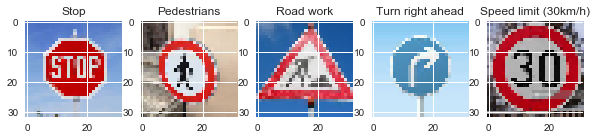

In [19]:
# Load the German traffic sign images downloaded from web
import os
web_images = os.listdir("web_images/")

web_imgs_X = []
for im_file in web_images:
    if im_file == ".DS_Store":
        continue
    img = plt.imread("web_images/"+ im_file)
    img = cv2.resize(img, (32, 32))                               
    web_imgs_X.append(img)

# Name the images
web_imgs_y = np.array([14, 27, 25, 33, 1])
web_imgs_signnames = []
for i in web_imgs_y:
    web_imgs_signnames.append(signnames["SignName"][i])

# Normalize the images
web_imgs_X_p = processing(web_imgs_X)

# Plot the images
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(10,4.5))
for i in range(len(web_imgs_X)):
    ax[i].set_title(web_imgs_signnames[i])
    ax[i].imshow(web_imgs_X[i])

My images are all bright, but the second image might be difficult to classify because the sign is a little bit of perspective.

### Predict the Sign Type for Each Image

Image1 Prediciton : Stop
Image2 Prediciton : Turn right ahead
Image3 Prediciton : Road work
Image4 Prediciton : Turn right ahead
Image5 Prediciton : Speed limit (30km/h)

Web Images Prediction Accuracy =  0.8


Image1 top 5 Soft Probabilites: 
Stop: 1.000
Speed limit (50km/h): 0.000
Speed limit (30km/h): 0.000
Keep right: 0.000
No vehicles: 0.000

Image2 top 5 Soft Probabilites: 
Turn right ahead: 0.635
Road work: 0.123
Speed limit (80km/h): 0.093
Speed limit (50km/h): 0.084
No passing for vehicles over 3.5 metric tons: 0.038

Image3 top 5 Soft Probabilites: 
Road work: 0.894
Wild animals crossing: 0.039
Double curve: 0.030
General caution: 0.029
Beware of ice/snow: 0.002

Image4 top 5 Soft Probabilites: 
Turn right ahead: 1.000
Speed limit (30km/h): 0.000
No vehicles: 0.000
Speed limit (70km/h): 0.000
Stop: 0.000

Image5 top 5 Soft Probabilites: 
Speed limit (30km/h): 1.000
Speed limit (20km/h): 0.000
Speed limit (50km/h): 0.000
Speed limit (120km/h): 0.000
Speed limit (80km/h): 0.000

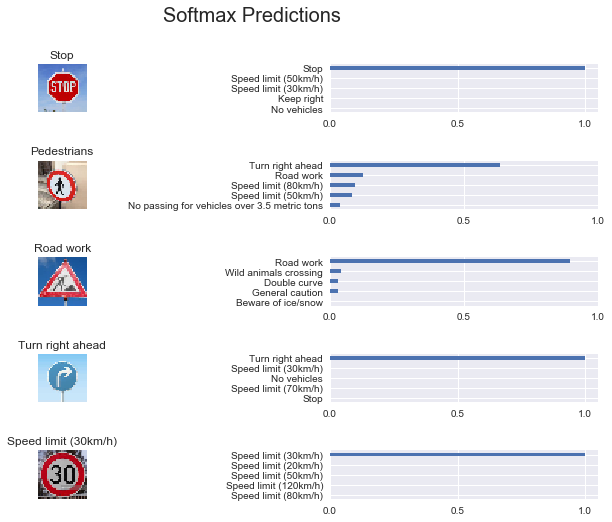

In [20]:
# Assess the prediction accuracy for each image
with tf.Session() as sess: 
    saver.restore(sess,'./traffic_sign_classifer')
    logits = sess.run(tf.nn.softmax(logits), feed_dict={x: web_imgs_X_p})
    n_predictions = 5
    predictions = sess.run(tf.nn.top_k(logits, n_predictions))

    count = 0
    for i in range(len(web_imgs_X)):
        prediction_type = signnames["SignName"][predictions.indices[i][0]]
        print("Image{} Prediciton : {}".format(i+1, prediction_type))
        # Calculate the accuracy for these 5 new images. 
        if predictions.indices[i][0] == web_imgs_y[i]:
            count += 1
    print()
    print("Web Images Prediction Accuracy = ", count/len(logits)) 
    print()
    
    # Calculate the top five softmax probabilities for the predictions on the German traffic sign images found on the web.      
    for i in range(len(web_imgs_X)):
        print("\nImage{} top 5 Soft Probabilites: ".format(i+1))
        for j in range(n_predictions):
            print("{}: {:.3f}".format(signnames["SignName"][predictions.indices[i][j]], predictions.values[i][j]))
    

    # Visualize the results
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 8))    
    plt.subplots_adjust(wspace =0.5, hspace =1)
    fig.suptitle('Softmax Predictions', fontsize=20)

    
    margin = 0.05
    index = np.arange(n_predictions)
    width = (2. - 2. * margin) / n_predictions

    for i, (img, pred_indicies, pred_values) in enumerate(zip(web_imgs_X, predictions.indices, predictions.values)):
        pred_names = [signnames["SignName"][j] for j in pred_indicies]
        correct_name = web_imgs_signnames[i]

        ax[i][0].imshow(img)
        ax[i][0].set_title(correct_name)
        ax[i][0].set_axis_off()

        ax[i][1].barh(index + margin, pred_values[::-1], width)
        ax[i][1].set_yticks(index + margin)
        ax[i][1].set_yticklabels(pred_names[::-1])
        ax[i][1].set_xticks([0, 0.5, 1.0])   
    
    

## Summerize

* The predictions on new images except the second one are quite certain, some were even 100% accuracy. It is very good. 

* Actually I used the same data to run the LeNex three times, and the results were different. The test on web images also had a quite diffent performance. First time the prediction accuracy was 0.8, only the pedestrain sign prediciton was wrong. Second time the prediction accuracy was 0.2, only the stop sign prediction was right. And the third time performance was similar to the first time.